# 现代循环神经网络
 首先，读取时间机器数据集

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import funcs


batch_size, num_steps = 32, 35
num_hiddens = 512
device = "cuda:0"
train_iter, vocab = funcs.load_data_time_machine(batch_size, num_steps, token_type="char")

## 门控循环单元（GRU）
从零开始实现

### 网络参数
重置门 $ R_t = \sigma (X_t W_{xr} + H_{t-1}W_{hr}+b_r ) $

更新门 $ Z_t = \sigma (X_t W_{xz} + H_{t-1}W_{hz}+b_z ) $ 

候选隐状态 $ \tilde{H_t} = tanh(X_{t}W_{xh} + (R_t \odot H_{t-1}) W_{hh} + b_h ) $

隐状态 $H_t = Z_t \odot H_{t-1} + (1 - Z_t) \odot \tilde{H_t} $

- 每当更新门 $Z_t$ 接近 $1$ 时，模型就倾向只保留旧状态。 此时，来自 $X_t$ 的信息基本上被忽略， 从而有效地跳过了依赖链条中的时间步 $t$ 。 相反，当 $Z_t$ 接近 $0$ 时， 新的隐状态 $H_t$ 就会接近候选隐状态 $\tilde{H_t}$ 。

In [3]:
# 获取初始参数：Wxr, Whr, br, Wxz, Whz, bz, Wxh, Whh, bh
def get_gru_params(embed_size:int, num_hiddens:int, device:str):
    """获取GRU中的所有参数:
    `W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q`
    """
    num_inputs = num_outputs = embed_size
    def wwb():
        return (torch.randn((num_inputs, num_hiddens), device=device)/100,
                torch.randn((num_hiddens, num_hiddens), device=device)/100,
                torch.zeros((num_hiddens), device=device),
        )
    W_xz, W_hz, b_z = wwb()
    W_xr, W_hr, b_r = wwb()
    W_xh, W_hh, b_h = wwb()
    W_hq = torch.randn((num_hiddens, num_outputs), device=device)/100
    b_q  = torch.zeros((num_outputs), device=device)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_gru_state(batch_size, num_hiddens, device):
    """ 初始化隐变量 """
    return torch.zeros((batch_size, num_hiddens), device=device)

In [4]:
def gru_forward(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H = state
    outputs = []
    for x in inputs:
        Z = torch.sigmoid((x @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((x @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((x @ W_xh) + ((R * H) @ W_hh) + b_h )
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), H

In [5]:
para  = get_gru_params(len(vocab), num_hiddens, device)
state = init_gru_state(2, num_hiddens, device)
x     = torch.ones((5,2,len(vocab)), device=device, dtype=torch.float)

y, state = gru_forward(x, state, para)
y.shape, state.shape

(torch.Size([10, 4598]), torch.Size([2, 512]))

In [6]:
gru = funcs.RNN(
    len(vocab), num_hiddens, device, get_gru_params, init_gru_state, gru_forward
)
funcs.rnn_predict("time ", 50, gru, vocab, device, True)

'time contrived shouted necessity suffering doubt mathematical close mathematical culminating blinding reversing instinct tranquil diminishing sweeping desiccated part zero generations puzzle acquaintance tire played fecundity attracted simple mine hairless vertically notion decorations results arrears arrears fighting excitement behoves refused cemeteries clung clung slumbering clung slumbering disk tatters hairless vertically notion decorations '

  0%|          | 0/1000 [00:00<?, ?it/s]

困惑度[1.47], 速度[12264.2 词元/秒], 设备[cuda:1]
time traveller came to the place reserved for him without a word he smiled quietly in his old way where s my mutton he said what a treat it is to stick a fork into meat again story cried the editor story be damned said the time traveller i want something to 
traveller it s against reason said filby what reason said the time traveller you can show black is white by argument said filby but you will never convince me possibly not said the time traveller but now you begin to see the object of my investigations into the geometry of four 


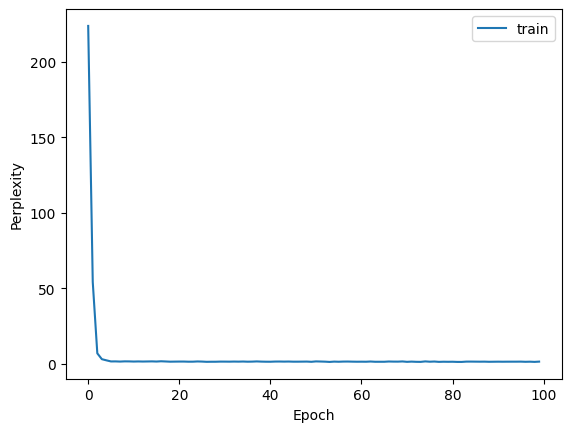

In [10]:
num_epochs = 1000
num_hiddens = 1024
lr = 9e-1
gru = funcs.RNN(
    len(vocab), num_hiddens, device, get_gru_params, init_gru_state, gru_forward
)
opt = torch.optim.SGD(gru.parameters(), lr, momentum=0.9)
# opt = torch.optim.Adam(gru.parameters(), lr)
ppls = funcs.train_rnn(gru, num_epochs, train_iter, opt, device, tqdm)
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 50, gru, vocab, device, True)
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppls)
plt.legend(["train"])

### 使用高级API实现

In [12]:
class RNN_(nn.Module):
    def __init__(self, layer:nn.RNN, device="cuda:1"):
        super().__init__()
        self.device = device
        self.layer = layer
        self.out_layer = nn.Linear(layer.hidden_size, layer.input_size, device=device)
    
    def forward(self, x:torch.Tensor, state:torch.Tensor):
        x = x.long().to(self.device)
        x = F.one_hot(x, self.layer.input_size).to(torch.float)
        y, state = self.layer(x, state)
        # y:[t,b,embed]  ->  [t*b, embed]
        out = self.out_layer(y.reshape((-1, self.layer.hidden_size)))
        return out, state
    
    def begin_state(self, batch_size:int, device:str):
        if isinstance(self.layer, nn.LSTM):
            return (torch.zeros((1, batch_size, num_hiddens), device=device),
            torch.zeros((1, batch_size, num_hiddens), device=device))
        else:
            return torch.zeros((1, batch_size, self.layer.hidden_size), 
                            dtype=torch.float, device=device)

        

  0%|          | 0/1000 [00:00<?, ?it/s]

困惑度[1.22], 速度[491010.5 词元/秒], 设备[cuda:1]
time traveller but now you begin to see theobject of my investigations into the geometry of four dimensions longag
traveller but now you begin to see theobject of my investigations into the geometry of four dimensions longag


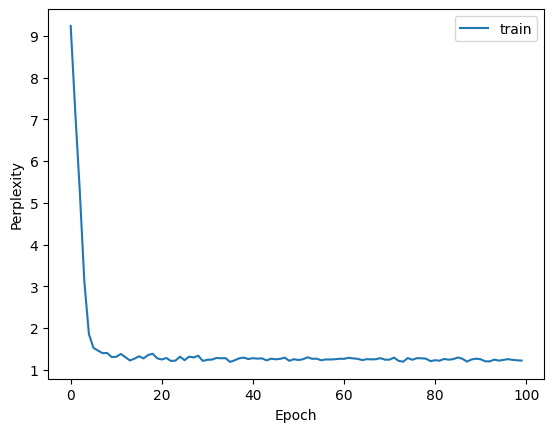

In [5]:
num_epochs = 1000
num_hiddens = 256
lr = 1

gru_layer = nn.GRU(len(vocab), num_hiddens, device=device, batch_first=True)
model = RNN_(gru_layer, device=device)

opt = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
# opt = torch.optim.Adam(gru.parameters(), lr)
ppls = funcs.train_rnn(model, num_epochs, train_iter, opt, device, tqdm, batch_first=True)
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 100, model, vocab, device, add_blank=False)
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppls)
plt.legend(["train"])

### GRU小结
- 门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
- 重置门有助于捕获序列中的短期依赖关系。
- 更新门有助于捕获序列中的长期依赖关系。
- 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。

## 长短期记忆网络（LSTM）
长期以来，隐变量模型存在着长期信息保存和短期输入缺失的问题。 解决这一问题的最早方法之一是长短期存储器（long short-term memory，LSTM）

假设有$h$个隐藏单元，批量大小为$n$，输入数为$d$。此时输入为$X_{t}\in \mathbb{R}^{n\times d}$，前一时间步的隐状态为$H_{t-1}\in \mathbb{R}^{n\times h}$。有如下的门：
- 输入门 $I_t \in \mathbb{R}^{n\times h}$
    - $I_t = \sigma (X_{t}W_{xi} + H_{t-1}W_{hi}+b_i)$
- 遗忘门 $ F_t \in \mathbb{R}^{n\times h} $
    - $F_t = \sigma (X_{t}W_{xf} + H_{t-1}W_{hf}+b_f)$
- 输出门 $O_t \in \mathbb{R}^{n \times h}$ 
    - $O_t = \sigma (X_{t}W_{xo} + H_{t-1}W_{ho}+b_o)$

其中 $W_{xi},W_{xf}, W_{xo} \in \mathbb{R}^{d \times h}$；$W_{hi},W_{hf}, W_{ho} \in \mathbb{R}^{h \times h}$；$b_{i},b_{f}, b_{o} \in \mathbb{R}^{1 \times h}$

- 候选记忆元 $ \tilde{C_t} \in \mathbb{R}^{n \times h}$
    - $\tilde{C_t}=tanh(X_{t}W_{xc}+H_{t-1}W_{hc}+b_{c})$,
- 记忆元 $C_t \in \mathbb{R}^{n \times h}$
    - $C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C_t}$
- 隐状态 $H_t \in \mathbb{R}^{n \times h}$
    - $H_t = O_t \odot tanh(C_t)$

只要输出门接近$1$，我们就能够有效地将所有记忆信息传递给预测部分， 而对于输出门接近$0$，我们只保留记忆元内的所有信息，而不需要更新隐状态。

In [2]:
def get_lstm_params(vocab_size:int, num_hiddens:int, device:str):
    """获取lstm中的网络参数"""
    num_inputs = num_outputs = vocab_size
    normal = lambda shape: torch.randn(size=shape, device=device)*1e-2
    wwb    = lambda : ( normal((num_inputs, num_hiddens)),
                        normal((num_hiddens, num_hiddens)),
                        torch.zeros(num_hiddens, device=device))
    W_xi, W_hi, b_i = wwb()
    W_xf, W_hf, b_f = wwb()
    W_xo, W_ho, b_o = wwb()
    W_xc, W_hc, b_c = wwb()
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [3]:
def init_lstm_state(batch_size:int, num_hiddens:int, device:str):
    """lstm的隐变量, 包含记忆元和隐状态"""
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [4]:
def lstm_forward(inputs:torch.Tensor, state:tuple[torch.Tensor,torch.Tensor], params:list):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    H, C = state
    outputs = []
    for X in inputs:
        # print(X.shape, H.shape, C.shape)
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.sigmoid((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)


  0%|          | 0/900 [00:00<?, ?it/s]

困惑度[1.30], 速度[30475.3 词元/秒], 设备[cuda:1]
time travellerit would be remarkably convenient for the historian the psychologistsuggested one might travel back and verify the accepted account ofthe battle of ha
traveller s returnxvi after the storyepilogueiintroductionthe time traveller for so it will be convenient to speak of him wasexpounding a recondite matter to u


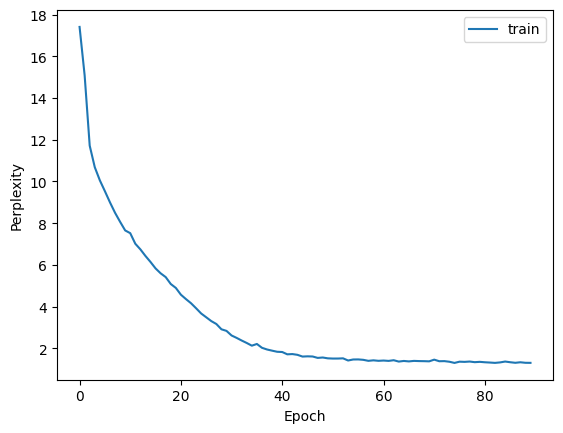

In [11]:
# batch_size, num_steps = 32, 35
num_epochs, lr = 900, 9e-1
device = "cuda:1"
num_hiddens = 512

# 初始化网络
lstm = funcs.RNN(
    len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm_forward
)
opt = torch.optim.SGD(lstm.parameters(), lr, momentum=0.9)
# opt = torch.optim.Adam(gru.parameters(), lr)
ppls = funcs.train_rnn(lstm, num_epochs, train_iter, opt, device, tqdm)
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 150, lstm, vocab, device, False)
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppls)
plt.legend(["train"])

### 使用高级API实现

  0%|          | 0/900 [00:00<?, ?it/s]

困惑度[1.24], 速度[140897.3 词元/秒], 设备[cuda:1]
time traveller s returnxvi after the storyepilogueiintroductionthe time traveller for so it will be convenient to speak of him wasexpounding a recondite matter to u
traveller proceeded anyreal body must have extension in four directions it must havelength breadth thickness and duration but through a naturalinfirmity of the


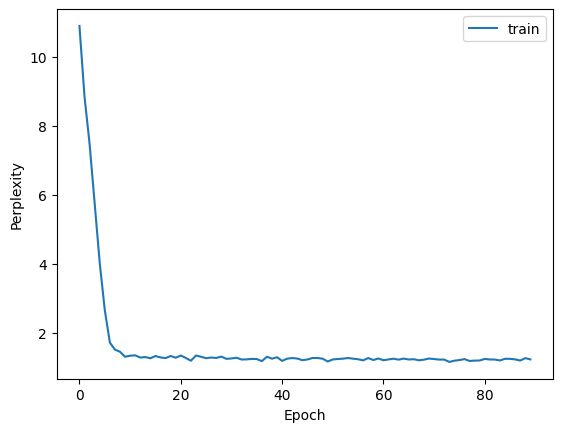

In [19]:
# batch_size, num_steps = 32, 35
num_epochs, lr = 900, 9e-1
device = "cuda:1"
num_hiddens = 512

lstm_layer = nn.LSTM(len(vocab), num_hiddens, batch_first=True, device=device)
lstm = RNN_(lstm_layer, device)

opt = torch.optim.SGD(lstm.parameters(), lr, momentum=0.9)
# opt = torch.optim.Adam(gru.parameters(), lr)
ppls = funcs.train_rnn(lstm, num_epochs, train_iter, opt, device, tqdm, batch_first=True)
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 150, lstm, vocab, device, False)
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppls)
plt.legend(["train"])

## 深度循环神经网络
通过`num_layers`的值来设定隐藏层的深度

  0%|          | 0/700 [00:00<?, ?it/s]

困惑度[1.26], 速度[80539.9 词元/秒], 设备[cuda:0]
time traveller after the pauserequired for the proper assimilation of this know very well that timeis only a kind of space here is a popular scientific diagram awea
traveller after the pauserequired for the proper assimilation of this know very well that timeis only a kind of space here is a popular scientific diagram awea


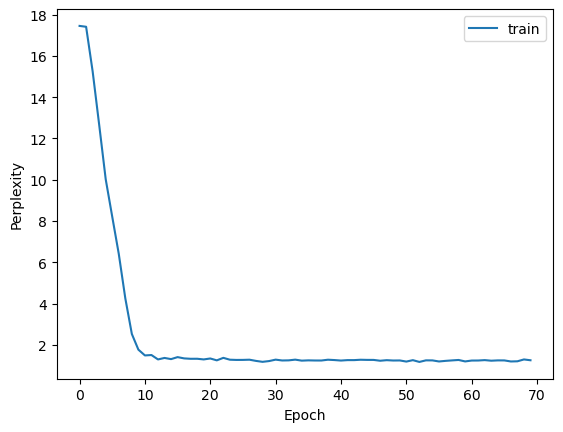

In [2]:
num_epochs, lr = 700, 1
num_hiddens, num_layers = 256, 3
device = "cuda:0"
lstm_layer = nn.LSTM(len(vocab), num_hiddens, num_layers, batch_first=True, device=device)
model = funcs.RNN_(lstm_layer, device, batch_first=True)


opt = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
# opt = torch.optim.Adam(gru.parameters(), lr)
ppls = funcs.train_rnn(model, num_epochs, train_iter, opt, device, tqdm, batch_first=True)
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 150, model, vocab, device, False)
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppls)
plt.legend(["train"])

## 双向模型
- 在双向循环神经网络中，每个时间步的隐状态由当前时间步的前后数据同时决定。
- 双向循环神经网络与概率图模型中的“前向-后向”算法具有相似性。
- 双向循环神经网络主要用于序列编码和给定双向上下文的观测估计。
- 由于梯度链更长，因此双向循环神经网络的训练代价非常高。

由于双向循环神经网络使用了过去的和未来的数据， 所以我们不能盲目地将这一语言模型应用于任何预测任务。 尽管模型产出的困惑度是合理的， 该模型预测未来词元的能力却可能存在严重缺陷。 

  0%|          | 0/500 [00:00<?, ?it/s]

困惑度[1.02], 速度[48055.8 词元/秒], 设备[cuda:0]
time travellerererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererer
travellerererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererer


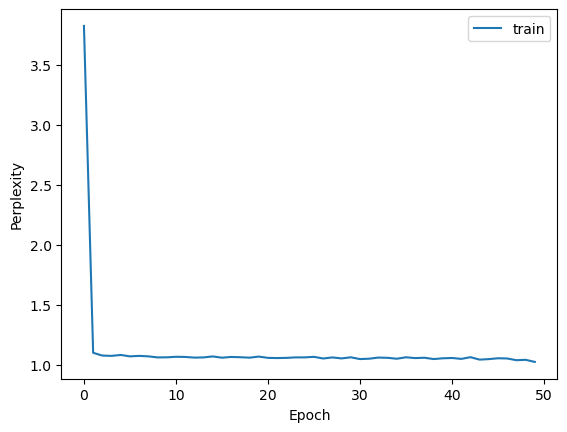

In [3]:
# 通过设置“bidirective=True”来定义双向LSTM模型
num_epochs, lr = 500, 1
device = "cuda:0"
num_hiddens, num_layers = 256, 2
lstm_layer = nn.LSTM(len(vocab), num_hiddens, num_layers, 
                    batch_first=True, bidirectional=True, device=device)

model = funcs.RNN_(lstm_layer, device, batch_first=True)

opt = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
# opt = torch.optim.Adam(gru.parameters(), lr)
ppls = funcs.train_rnn(model, num_epochs, train_iter, opt, device, tqdm, batch_first=True)
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 150, model, vocab, device, False)
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppls)
plt.legend(["train"])